# GSAT by IPCC regions

In [1]:
import timeit
import zipfile
import requests
import json

from utils import find_region, find_region_bbox

import numpy as np
import pandas as pd
import netCDF4
import xarray
import dask

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import ipywidgets as widgets

In [3]:
%matplotlib inline

In [4]:
dask.config.set(scheduler="processes")

plt.rcParams["figure.figsize"] = 12, 6

## Introduction

## IPCC regions

The IPCC AR6 reference regions are standardized spatial domains defined for climate model evaluation and communication of regional climate change information. They’re used in the Atlas chapter of the AR6 Working Group I Report and are available as shapefiles or GeoJSON data.

In [5]:
regions_url = "https://raw.githubusercontent.com/IPCC-WG1/Atlas/refs/heads/main/reference-regions/IPCC-WGI-reference-regions-v4.geojson"
regions_file = regions_url.split("/")[-1]

with open(regions_file, "w") as f:
    r = requests.get(regions_url)
    r.raise_for_status()
    f.write(r.text)

with open(regions_file, "r") as f:
    regions = json.load(f)

IPCC AR6 reference regions include:

- Land regions (e.g., WCE — Western Central Europe, EAS — East Asia)
- Marine regions (e.g., NPO — North Pacific Ocean)
- Combined “reference regions” for climate impact assessments

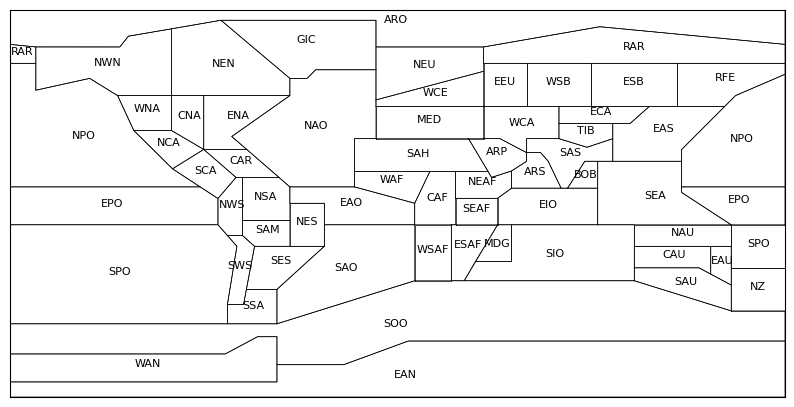

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

m = Basemap(
    llcrnrlon=-180, urcrnrlon=180,
    llcrnrlat=-90, urcrnrlat=90,
    resolution="i", ax=ax)

def plot_polygon(coordinates, text, **kwargs):
    for polygon in coordinates:
        x, y = zip(*polygon)
        x, y = m(x, y)  # convert to map projection
        m.plot(x, y, marker=None, **kwargs)

        flat_coords = [point for ring in coordinates for point in ring]
        avg_lon = sum(point[0] for point in flat_coords) / len(flat_coords)
        avg_lat = sum(point[1] for point in flat_coords) / len(flat_coords)
        cx, cy = m(avg_lon, avg_lat)
        ax.text(cx, cy, text, fontsize=8, ha="center", color="black")

for feature in regions["features"]:
    geometry = feature["geometry"]
    geom_type = geometry["type"]
    label = feature["properties"]["Acronym"]

    if geom_type == "Polygon":
        plot_polygon(geometry["coordinates"], label, color="black", lw=.5)

    elif geom_type == "MultiPolygon":
        for polygon in geometry["coordinates"]:
            plot_polygon(polygon, label, color="black", lw=.5)

## Loading ESGF data

In [7]:
query = (
    'variable == "tas" & '
    'table == "Amon" & '
    '(experiment == "historical" | experiment == "ssp585") & '
    'replica == "esgf.ceda.ac.uk"')

catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("").query(query)

catalog["dataset_id"] = catalog[
    ["project", "product", "institution", "model", "experiment", "table", "variable", "grid_label", "version"]
].agg(".".join, axis=1)

/tmp/ipykernel_215367/211782750.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("").query(query)


### Choosing a dataset

In [8]:
dataset = widgets.SelectMultiple(
    options=catalog["dataset_id"].unique(),
    value=[
        'CMIP6.CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.tas.gn.v20200212',
        'CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.tas.gr.v20200310',
        'CMIP6.CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.tas.gr1.v20190726',
        'CMIP6.CMIP.SNU.SAM0-UNICON.historical.Amon.tas.gn.v20190323'],
    description="Dataset:",
    layout=widgets.Layout(width='750px', height='200px'),
)
display(dataset)

SelectMultiple(description='Dataset:', index=(2, 56, 134, 138), layout=Layout(height='200px', width='750px'), …

### Choosing a region

In [9]:
region_drop = widgets.Dropdown(
    options=[(region["properties"]["Acronym"], i) for i, region in enumerate(regions["features"])],
    label="SAM",
    description="Dataset:",
)
display(region_drop)

Dropdown(description='Dataset:', index=12, options=(('GIC', 0), ('NWN', 1), ('NEN', 2), ('WNA', 3), ('CNA', 4)…

In [10]:
region = find_region(region_drop.label, regions)
bbox = find_region_bbox(region)
print(region["properties"])

{'id': '12', 'Continent': 'SOUTH-AMERICA', 'Type': 'Land', 'Name': 'South-American-Monsoon', 'Acronym': 'SAM'}


Plot the region of interest.

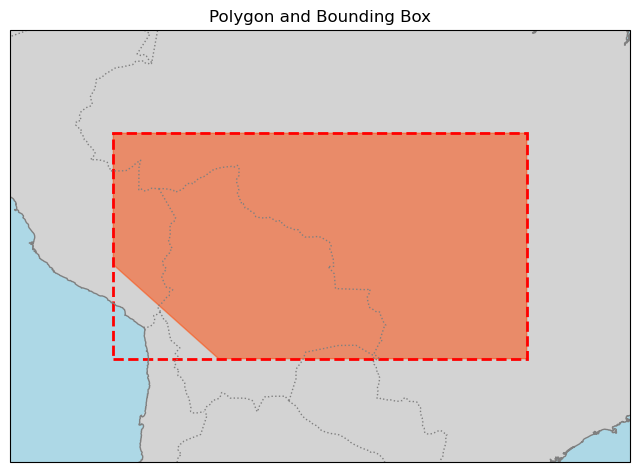

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot polygon
coords = region["geometry"]["coordinates"][0]
poly_patch = Polygon(coords, closed=True, fill=True, color="orangered", alpha=.5)
ax.add_patch(poly_patch)

# Plot bounding box
rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                 linewidth=2, edgecolor="red", facecolor="none", linestyle="--")
ax.add_patch(rect)

# Add labels and grid
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Polygon and Bounding Box")
ax.grid(True)

# Adjust plot limits
ax.set_xlim(bbox[0] - 5.5, bbox[2] + 5.5)
ax.set_ylim(bbox[1] - 5.5, bbox[3] + 5.5)

ax.coastlines(resolution="10m", color="gray")
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

plt.show()

## GSAT for the IPCC region

In [12]:
dss = [
    xarray.open_dataset(
    catalog[catalog["dataset_id"] == x]["location"].iloc[0]).sel(time=slice("19950101", "20141231")).chunk({"time": 240, "variant_label": 1})
    for x in dataset.value]

In [13]:
dss180 = []
for ds in dss:
    ds180 = ds.assign_coords(lon=(((ds["tas"].coords["lon"] + 180) % 360) - 180))
    ds180 = ds180.sortby(ds180.coords["lon"])
    dss180.append(ds180)

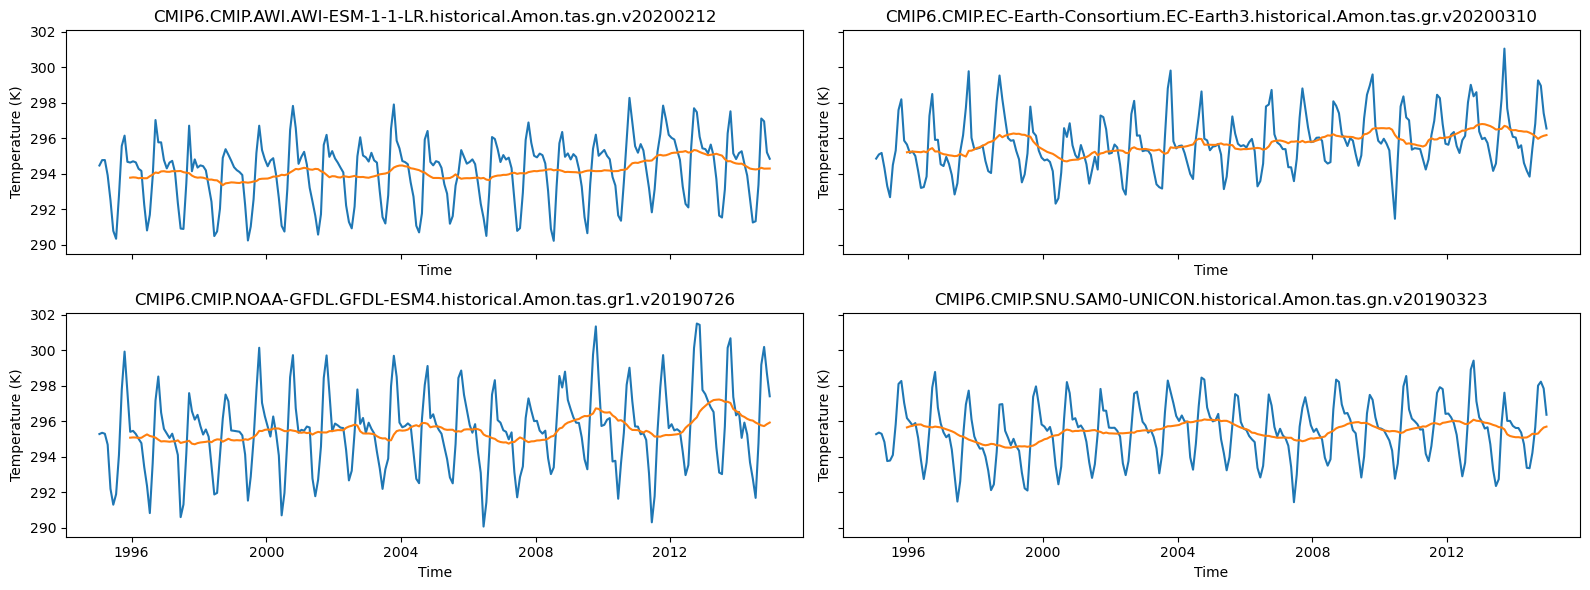

In [14]:
n = len(dss180)
ncols = int(n**0.5)
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 3*nrows), sharex=True, sharey=True)
axes = axes.flatten()

for i, ds in enumerate(dss180):
    ax = axes[i]
    da = ds["tas"].isel(variant_label=0) \
        .sel(lat=slice(bbox[1], bbox[3])).load() \
        .sel(lon=slice(bbox[0], bbox[2])) \
        .convert_calendar("gregorian")
    da_mean = da.mean(dim=["lat", "lon"])
    da_mean.plot(ax=ax)

    da_roll = da_mean.rolling(time=12).mean()
    da_roll.plot(ax=ax)

    ax.set_title(f"{dataset.value[i]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (K)")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

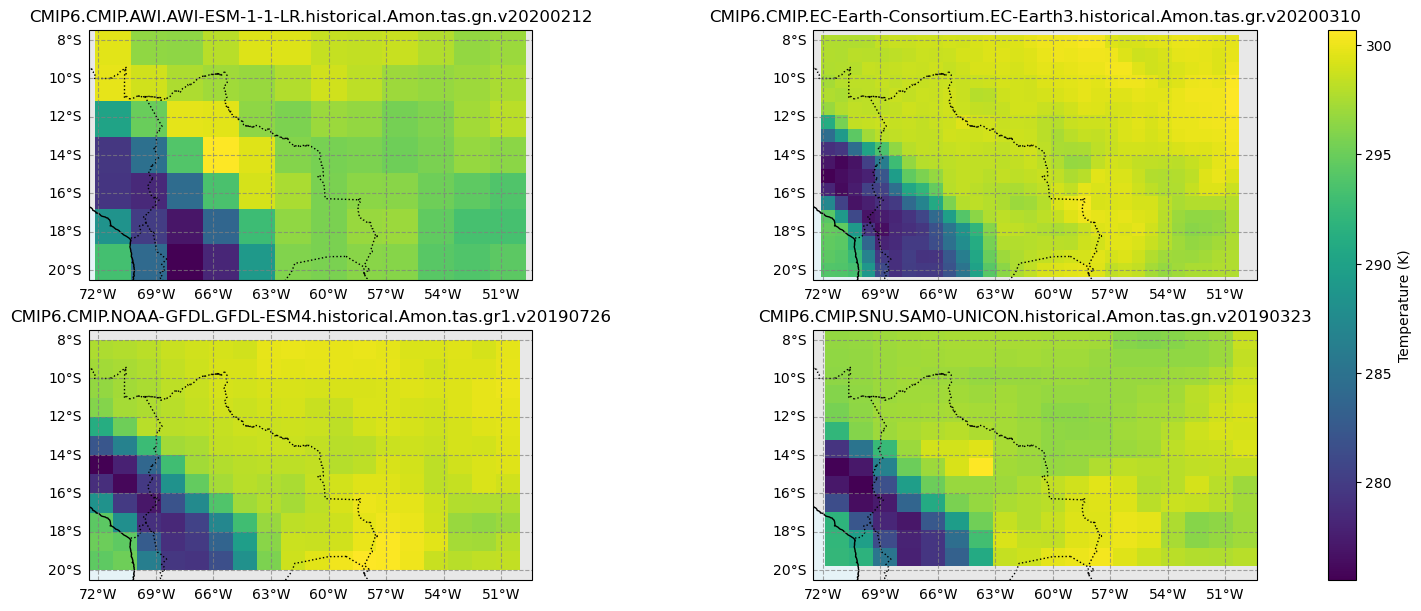

In [15]:
n = len(dss180)
ncols = int(n**0.5)
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(
    nrows, ncols, figsize=(8*ncols, 3*nrows), sharex=True, sharey=True,
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True)
axes = axes.flatten()
mappable = None

for i, ds in enumerate(dss180):
    ax = axes[i]
    da = ds["tas"].isel(variant_label=0) \
        .sel(lat=slice(bbox[1], bbox[3])) \
        .sel(lon=slice(bbox[0], bbox[2])) \
        .mean("time")
    
    p = da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False)
    mappable = p

    ax.set_title(f"{dataset.value[i]}")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.3)

    gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

cbar = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.04, pad=0.05)
cbar.set_label('Temperature (K)')

plt.show()